# A notebook for development and testing

In [28]:
import torch
from torch import nn
import torch.functional as F
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import MultiStepLR

from lion_pytorch import Lion

import pandas as pd
import scanpy as sc
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import lightning.pytorch as pl

from pytorch_lightning.loggers import WandbLogger
from lightning.pytorch.callbacks import Callback, ModelCheckpoint
from pytorch_metric_learning.samplers import  MPerClassSampler
import wandb

import networkx as nx


### Useful links
https://arxiv.org/pdf/2210.10946.pdf

https://arxiv.org/pdf/2112.15089.pdf

https://arxiv.org/pdf/2301.08110.pdf

https://nn.labml.ai/graphs/gatv2/index.html

## Define Dataloader

In [108]:
class ObsDataset(pl.LightningDataModule):
    def __init__(self, file, batch_size=2048, num_workers=1, train_split=0.9, toy=False, normalize=False, interventional=True):

        super().__init__()
        
        self.interventional = interventional
        
        self.file = file
        self.batch_size = batch_size
        self.train_split = train_split
        self.num_workers = num_workers
        self.toy = toy
        self.normalize = normalize
        
        self._load_data()
        
        self.n_genes = len(self.adata.var)
        self.n_cells = len(self.adata.obs)
        
        #del self.adata
        
    def _load_data(self):
        self.adata = sc.read_h5ad(self.file)
        self.adata.var.index = self.adata.var.gene_name
        self.adata[:, ~self.adata.var.index.duplicated(keep='first')]
        
        def remove_generic_proteins(x):
            return not ('RPL' in x or 'RPS' in x or 'MT' in x)
        remove_generic_proteins = np.vectorize(remove_generic_proteins) 

        self.adata = self.adata[:, remove_generic_proteins(self.adata.var.gene_name)]

        
        if self.toy:
            self._make_toy_dataset()
        else:
            self.X = self.adata.X
        self.genes = np.array(self.adata.var.gene_name)
        

        
        if self.interventional:
            get_gene_idx = lambda x: np.where(self.genes == x)[0][0] if x in self.genes else -1

            pert_idxs = self.adata.obs.gene.apply(get_gene_idx).values

            self.X = np.concatenate((self.X, pert_idxs[:, None]), axis=1)
            
        
    def _make_toy_dataset(self):
        sc.pp.subsample(self.adata, n_obs=10000)
        self._load_interaction_datasets()
        
        self.prepare_data(self.normalize)
        
        self.adata = self.adata[:, self.adata.var.gene_name.isin(self.selected_genes)]
        self.X = self.adata.X.toarray()
        
    def prepare_data(self, normalize=False):
        
        #max_val = np.apply_along_axis(lambda x: np.percentile(x, 0.99), 0, self.adata.X)
        #for i in range(self.n_genes):
        #    self.adata.X[self.adata.X[:, i] > max_val[i], i] = max_val[i]
            
        if normalize:
            sc.pp.normalize_per_cell(self.adata, key_n_counts='UMI_count')
            sc.pp.log1p(self.adata)  

            
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            train_size = int(self.n_cells * self.train_split)
            val_size = self.n_cells - int(self.n_cells * self.train_split)
            self.train, self.val = random_split(self.X, [train_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.train,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=False)
    
    def _load_interaction_datasets(self, n_genes=500):
    
        np.random.seed(0)

        eval_dir = '/home/artemy/causal_proj/data/competition_data/eval_metrics/'
        chip_data = pd.read_csv(eval_dir + 'K562_ChipSeq.csv', index_col=0)

        self.regulator = 'BDP1'
        self.regulon = chip_data.loc[chip_data['source'] == self.regulator, 'target']
        self.regulon = self.regulon[self.regulon.isin(self.adata.var.gene_name)].tolist()

        genes_not_in_regulon = self.adata.var.gene_name[~self.adata.var.gene_name.isin(self.regulon + [self.regulator])].tolist()
        additional_genes = np.random.choice(genes_not_in_regulon, 500-len(self.regulon) - 1, replace=False).tolist()

        self.additional_genes = additional_genes
        self.selected_genes = [self.regulator] + self.regulon + additional_genes


        protein_info = pd.read_csv(eval_dir + 'protein.info.txt.gz', sep='\t')
        ensp2gs = dict(zip(protein_info.iloc[:, 0], protein_info.iloc[:, 1]))

        protein_links = pd.read_csv(eval_dir + 'protein.links.txt.gz', sep=' ')
        protein_links['protein1'] = protein_links['protein1'].apply(lambda x: ensp2gs[x])
        protein_links['protein2'] = protein_links['protein2'].apply(lambda x: ensp2gs[x])
        self.protein_links = protein_links[protein_links['protein1'].isin(self.selected_genes) \
                                                   & protein_links['protein2'].isin(self.selected_genes)]



## Helper functions and classes

In [30]:
def init_weights(m, activation='relu'):
    if isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    
    if activation == 'silu':
        if isinstance(m, nn.Conv1d):
            n = m.kernel_size[0] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2 / n))
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.001)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0) 
        elif isinstance(m, nn.Embedding):
            m.weight.data.normal_(0, 0.001)
          
    else:
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            m.bias.data.fill_(0.01) 
        elif isinstance(m, nn.Embedding):
            torch.nn.init.kaiming_uniform_(m.weight)

In [31]:
def max_over_embeds(x, y):
    return torch.max(torch.concat((x[:, :, :, None], y[:, :, :, None]), 3), 3)[0]

In [32]:
class MaskedAttention(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.ll = nn.Linear(input_dim, input_dim)
        self.ll2 = nn.Linear(input_dim, input_dim)
        
        
        
    def _choose_function(self, function):
        if function == 'sigmoid':
            func = torch.sigmoid
        elif function == 'tanh':
            func = torch.tanh
        elif function == 'softmax':
            func = lambda x: torch.softmax(x, -1)
        elif function == 'softmax_t':
            func = lambda x: torch.softmax(x, -2)

        return func
                    
    def forward(self, x, y, hidden_idxs=None, function='sigmoid'):
        x = self.ll(x)       
        
        
        if x.dim() == 3:
            att = torch.einsum('btk, blk -> btl', x, x)  
        elif x.dim() == 2:
            att = torch.einsum('tk, lk -> tl', x, x)            
            
        func = self._choose_function(function)
        
        att = func(att)
                
        return att 

In [33]:
class BatchNormEmbed(nn.Module):
    def __init__(self, input_size, embed_size):
        super().__init__()
    
        self.input_size = input_size
        self.embed_size = embed_size
        self.bn = nn.BatchNorm1d(self.input_size * self.embed_size)
        
    def forward(self, x):
        shape = x.shape
        x = torch.flatten(x, 1)
        x = self.bn(x)
        x = x.reshape(shape)
        return x
    
    
class BatchNormRotating(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.embed_size = embed_size
        self.bn = nn.BatchNorm1d(self.embed_size)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.bn(x)
        x = x.permute(0, 2, 1)
        return x


class AttBlock(nn.Module):
    def __init__(self, input_size, embed_size):
        super().__init__()
    
        self.input_size = input_size
        self.embed_size = embed_size
        
        self.act = nn.SiLU()
        self.ll1 = nn.Linear(self.embed_size, self.embed_size)

        
        self.bn_attn1 = BatchNormRotating(self.embed_size)
        self.bn1 = BatchNormRotating(self.embed_size)
        
    def forward(self, x, attn_weights):
    
        attn_output1 = torch.einsum('bjk, lj -> blk', x, attn_weights)
        
        
        #attn_output1 = (attn_output1 + x)  / 2 ** 0.5
        attn_output1 = self.bn_attn1(attn_output1)

        ll_output1 = self.ll1(attn_output1)
        #ll_output1 = (attn_output1 + ll_output1)  / 2 ** 0.5
        ll_output1 = self.bn1(ll_output1)
        ll_output1 = self.act(ll_output1)
        
        return ll_output1

## Define model

In [37]:
class Model(pl.LightningModule):
    def __init__(self, genes, n_genes_in_minibatch, 
                     embed_size=20, lr=0.001, perc_hidden=0.25, wd=0.01, regime='interventional'):
        super().__init__()
        self.genes = genes
        self.n_genes = len(self.genes)
        self.n_genes_in_minibatch = n_genes_in_minibatch
        self.embed_size = embed_size
        self.lr = lr
        self.wd = wd
        self.perc_hidden = perc_hidden
        self.calculate_attention = True
        self.regime = regime
        
        self.act = nn.SiLU()
        self.embedding = nn.Embedding(self.n_genes, embed_size)

        self.ll0 = nn.Linear(self.embed_size+1, self.embed_size+1)
        self.bn0 = BatchNormRotating(self.embed_size+1)
        
        self.ll_pre = nn.Linear(self.embed_size+1, self.embed_size+1)
        self.bn_pre = BatchNormRotating(self.embed_size+1)
        
        
        self.attn = MaskedAttention(self.embed_size)
       
        self.att_block1 = AttBlock(self.n_genes_in_minibatch, self.embed_size+1)


        self.ll_prefin = nn.Linear(self.embed_size+1, self.embed_size+1)
        self.bn_prefin = BatchNormRotating(self.embed_size+1)
        

        self.ll_fin = nn.Linear(self.embed_size+1, 1)
        
        self.model = nn.ModuleList(
                             [self.embedding, self.attn, 
                              self.ll0, self.bn0,
                              self.ll_pre, self.bn_pre,
                              self.att_block1,                           
                              self.ll_prefin, self.bn_prefin, self.ll_fin]
                    )
        
        self.loss_fn = nn.HuberLoss()
        self.save_hyperparameters(logger=False)
        self.model.apply(lambda x: init_weights(x, activation='silu'))
                
        
    def _common_step(self, batch, batch_idx):
        x = batch.float()
        if self.regime == 'interventional':
            interventions = x[:, -1].int()
            x = x[:, :-1]
                
        
        gene_mask = self._generate_random_mask(self.n_genes, self.n_genes_in_minibatch)
        gene_idxs = torch.where(gene_mask)[0]
        x = x[:, gene_mask]

        self.hidden_mask = self._generate_2D_random_mask(self.n_genes_in_minibatch, 
                                     int(self.n_genes_in_minibatch * self.perc_hidden), len(x))
        
            
        x_corrupted = torch.clone(x)
        x_corrupted[self.hidden_mask] = x_corrupted[self.hidden_mask][torch.randperm(len(x_corrupted[self.hidden_mask]))]
        
        preds, attn_weights = self.forward(x_corrupted, gene_idxs)
        
        
            
        loss =  .7 * self.loss_fn(preds[self.hidden_mask], x[self.hidden_mask]) + \
                    .3 * self.loss_fn(preds[~self.hidden_mask], x[~self.hidden_mask])
        
        if self.regime == 'interventional':
            loss += self._calculate_interventional_loss(x, preds, self.hidden_mask, attn_weights, interventions, gene_idxs)
  
        return loss, preds[self.hidden_mask], x[self.hidden_mask]
    
    
    def _calculate_interventional_loss(self, x, preds, hidden_mask, attention_matrix, interventions, gene_idxs):
        
        huber = nn.HuberLoss(reduction='none')
        mse = nn.MSELoss(reduction='none')
        sigmoid = nn.Sigmoid()
        softmax = nn.Softmax()
        tanh = nn.Tanh()
        
        intervention_types = torch.unique(interventions)
        
        l = 0

        for interven in intervention_types:
            if interven in gene_idxs:
                interv_x = x[interventions==interven]
                non_interv_x = x[interventions!=interven]
                interv_preds = preds[interventions==interven]
                non_interv_preds = preds[interventions!=interven]
                
                
                m1 = huber(interv_x, interv_preds).mean(0)
                m2 = huber(non_interv_x, non_interv_preds).mean(0)

                
                coefs = sigmoid(m2 / m1 - 1)
                
                l += mse(attention_matrix[:, gene_idxs==interven], coefs).mean()
                
        l = l / (len(intervention_types) - 1)

        return l
    
    
        
    def forward(self, x, gene_idxs):

        x_emb = self.embedding(gene_idxs)


        attn_weights = self.attn(x_emb, x_emb, function='softmax')

        x_emb = x_emb[None, :, :].repeat((x.shape[0], 1, 1))
        x = x[:, :, None]
        x = torch.concat((x, x_emb), 2)
        
        x = self.ll0(x)
        x = self.bn0(x)
                            
        x = self.ll_pre(x)
        x = self.bn_pre(x)
        
        attn_output1 = self.att_block1(x, attn_weights)

        combined = (attn_output1) 
        
        combined = self.ll_prefin(combined)

        
        res = self.ll_fin(combined)
        res = res.squeeze(2)
        
        return res, attn_weights
    
    
    def _generate_random_mask(self, total_size, sample_size):
        mask = torch.full((total_size,), False, dtype=bool)
        mask[:sample_size] = True
        mask = mask[torch.randperm(total_size)].to(self.device)
        return mask
    
    def _generate_2D_random_mask(self, total_size, sample_size, bs):
        mask = torch.full((bs, total_size), False, dtype=bool)
        
        col_idxs = torch.concat([torch.randperm(total_size)[:sample_size] for i in range(bs)])
        row_idxs = torch.tile(torch.arange(bs), (sample_size,))
        
        mask[row_idxs, col_idxs] = True
        
        mask = mask.to(self.device)
        
        return mask
    
    def calculate_attention_matrix(self):
        x_emb = self.embedding(torch.arange(self.n_genes).to(self.device))
        self.attention_matrix = self.attn(x_emb, x_emb, function='softmax')
        self.attention_matrix = self.attention_matrix.detach().cpu().numpy()
        
    def training_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        
        self.log('train_loss', loss)
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log('val_loss', loss)
        return loss
        
    def test_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log('test_loss', loss)
        return loss
    
    def predict_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        return scores, y
    
    def configure_optimizers(self, optimizer='lion', use_scheduler=True):
        if optimizer=='adamw':
            optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.wd)
        elif optimizer=='lion':
            optimizer = Lion(self.parameters(), lr=self.lr, weight_decay=self.wd)
        if use_scheduler:
            scheduler = MultiStepLR(optimizer, milestones=[100], gamma=0.01)
            return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]
        else:
            return optimizer
    
    def lr_scheduler_step(self, scheduler, metric):
        scheduler.step()

## Run model

In [38]:
# wandb.finish()

In [39]:
# wandb_logger = WandbLogger(name='full dataset, all genes at once', project='new res')


In [109]:
dataset = '/home/artemy/causal_proj/data/competition_data/datasets/k562.h5ad'
data = ObsDataset(dataset, toy=False, normalize=False)

In [ ]:
N_SAMPLE_GENES = 500
LR = .0001
WD=0.05
PERC_HIDDEN = 0.80


model = Model(data.genes, N_SAMPLE_GENES, lr=LR, perc_hidden=PERC_HIDDEN, wd=WD)


ACCELERATOR = 'gpu'
DEVICES = [0]
NUM_EPOCHS = 25

ckpt_dir = '/home/artemy/causal_proj/data/models/start/full_dataset_interv_25_wd=0.3/'

torch.set_float32_matmul_precision('medium')


trainer = pl.Trainer(
#        logger=wandb_logger,
        accelerator=ACCELERATOR,
        devices=DEVICES,
        min_epochs=1,
        max_epochs=NUM_EPOCHS,
        log_every_n_steps=5,
         callbacks = [
                         ModelCheckpoint(every_n_epochs = 1, 
                                  dirpath = ckpt_dir, save_top_k=-1)]
    )

trainer.fit(model, data)


In [1452]:
# ckpt_dir = '/home/artemy/causal_proj/data/models/start/full_dataset_interv_25_wd=0.05_mse_sched/'
# os.listdir(ckpt_dir)

['epoch=13-step=1918.ckpt',
 'epoch=5-step=822.ckpt',
 'epoch=12-step=1781.ckpt',
 'epoch=6-step=959.ckpt',
 'epoch=7-step=1096.ckpt',
 'epoch=2-step=411.ckpt',
 'epoch=11-step=1644.ckpt',
 'epoch=3-step=548.ckpt',
 'epoch=9-step=1370.ckpt',
 'epoch=1-step=274.ckpt',
 'epoch=10-step=1507.ckpt',
 'epoch=0-step=137.ckpt',
 'epoch=4-step=685.ckpt',
 'epoch=8-step=1233.ckpt']

In [1453]:
# N_SAMPLE_GENES = len(data.genes)

# model = Model(data.genes, N_SAMPLE_GENES, lr=LR, perc_hidden=PERC_HIDDEN, wd=WD)


# model = model.load_from_checkpoint(ckpt_dir + 'epoch=13-step=1918.ckpt')

## Analyze results

In [111]:
eval_dir = '/home/artemy/causal_proj/data/competition_data/eval_metrics/'

protein_info = pd.read_csv(eval_dir + 'protein.info.txt.gz', sep='\t')
ensp2gs = dict(zip(protein_info.iloc[:, 0], protein_info.iloc[:, 1]))

protein_links = pd.read_csv(eval_dir + 'protein.links.txt.gz', sep=' ')
protein_links['protein1'] = protein_links['protein1'].apply(lambda x: ensp2gs[x])
protein_links['protein2'] = protein_links['protein2'].apply(lambda x: ensp2gs[x])


protein_links = protein_links[protein_links['protein1'].isin(data.genes) \
                                           & protein_links['protein2'].isin(data.genes)]

#protein_links = protein_links[protein_links['combined_score'] > 900]

protein_links.index = protein_links['protein1'] + '_' + protein_links['protein2']

In [113]:
model.calculate_attention_matrix()
att = pd.DataFrame(model.attention_matrix, index=data.genes, columns=data.genes)

att.iloc[range(len(att)), range(len(att))] = 0


In [114]:
att = np.maximum(att, att.T)

In [115]:
att.iloc[:, :] = np.triu(att)

In [138]:
n = 500
nth_el = np.sort(att.values.flatten())[-n]

Adj = (att >= nth_el).astype(int)

In [139]:

g_helper = nx.from_numpy_array(Adj.values)

labeldict = dict(zip([i for i in range(len(Adj.index))], Adj.index))
g_helper = nx.relabel_nodes(g_helper, labeldict)

discovered_edges = g_helper.edges


#discovered_edges_names = [tuple(sorted([edge[0], edge[1]])) for edge in discovered_edges] 
discovered_edges_names = [edge[0] + '_' + edge[1] for edge in set(discovered_edges)] 


relevant_items = set(discovered_edges_names) & set(protein_links.index)


In [140]:
print(f'The rate of correct findings: {len(relevant_items) / n}')

The rate of correct findings: 0.582


### Plot the results

In [147]:
def draw_graph(G, nodes=[], edge_colors='grey'):
    plt.figure(figsize=(15, 18))

    pos = nx.kamada_kawai_layout(G)

    node_color=['red' if node in nodes else 'green' for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=100, alpha=0.3)
    nx.draw_networkx_labels(G, pos)

    nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color=edge_colors, arrows=True, width=1)#, arrowstyle= '-|>'


In [148]:
for edge in relevant_items:
    Adj.loc[edge.split('_')[0], edge.split('_')[1]] = 2

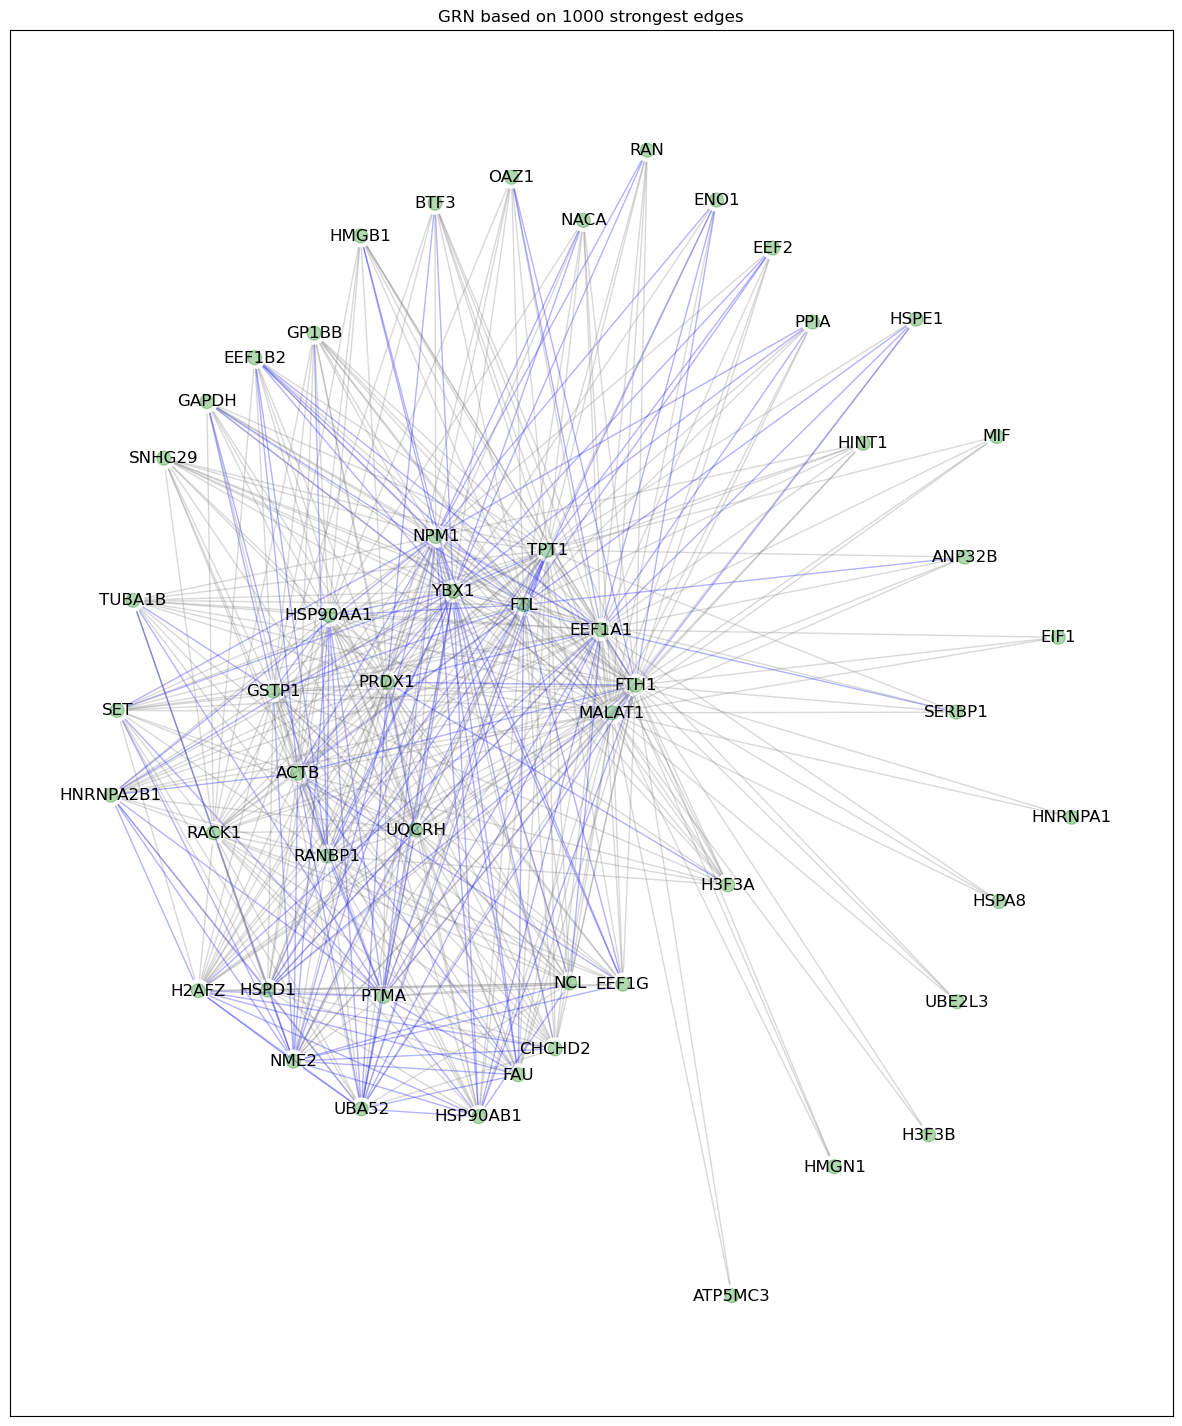

In [149]:

G = nx.from_numpy_array(Adj.values.astype('bool'))
labeldict = dict(zip([i for i in range(len(Adj.index))], Adj.index))
G = nx.relabel_nodes(G, labeldict)

components = sorted(nx.connected_components(G), key=len, reverse=True)
components = [comp for comp in components if len(comp) > 1]
components = set().union(*components)

G = G.subgraph(components)
col_di = {0:'grey', 1:'grey', 2:'blue'}
edge_colors = [col_di[Adj.loc[edge[0], edge[1]]] for edge in nx.edges(G)]
draw_graph(G, [], edge_colors=edge_colors)

plt.title('GRN based on 1000 strongest edges')
plt.show()


Here the blue edges represent association between genes which is documented in string database